![image.png](https://i.imgur.com/a3uAqnb.png)


# **Day 2) ML Regression for Sales.**

---
In this lab, you'll learn how to preprocess tabular data and implement:


1. **Linear Regression** (from scratch)

2. **Ridge Regression**

3. **LASSO Regression**

4. **Support Vector Machine (Regressor)**

5. **Decision Tree Regressor**

6. **Random Forest Regressor**

7. **LightGBM Regressor**

8. **CatBoost Regressor**

---

# 📊 **Data**
https://www.kaggle.com/datasets/bumba5341/advertisingcsv

> This dataset's goal is to predict `Sales` (**regression**) based on advertising budgets for TV, Radio, and Newspaper.


# 1️⃣ Import Libraries


In [ ]:
from IPython.display import clear_output

%pip install kagglehub catboost lightgbm tqdm -q

clear_output()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os
from tqdm import tqdm

%matplotlib inline

# 2️⃣ Read the Data


In [ ]:
# Download latest version
path = kagglehub.dataset_download("bumba5341/advertisingcsv")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'advertisingcsv' dataset.
Path to dataset files: /kaggle/input/advertisingcsv


In [ ]:
csv_path = os.path.join(path, "Advertising.csv")

df = pd.read_csv(csv_path)
df = df.drop(columns="Unnamed: 0", axis=1)
df.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


# 3️⃣ Exploratory Data Analysis (EDA)

**Rule of thumb checklist:**

| Question | If YES | If NO |
|----------|--------|-------|
|  **Is the target skewed?** | Consider log transform | Proceed |
|  **Missing values?** | Impute or drop | Proceed |
|  **Categorical columns?** | Encode them | Proceed |
|  **Duplicates?** | Drop them | Proceed |
|  **Different scales?** | Standardize (except tree models) | Proceed |


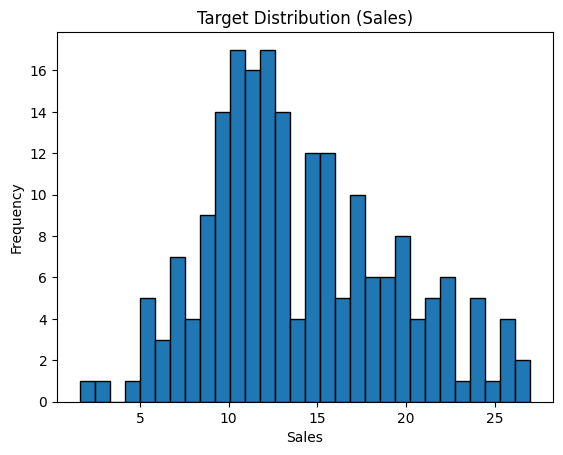

In [ ]:
# 1. What does our target variable (charges) look like?
def check_target_distribution(df, target_column):
  df[target_column].hist(bins=30, edgecolor='black')

  plt.title(f"Target Distribution ({target_column})")
  plt.xlabel(target_column)
  plt.ylabel("Frequency")
  plt.grid(False)

  plt.show()

check_target_distribution(df, "Sales") #set target column to "Newspaper" for a skewed distibution

> **Rule of thumb:** For regression, if the target is heavily skewed, we might apply a log transform. However, for this lab we'll work with the raw values.


In [ ]:
# 2. Do we have missing values?
def check_missing_values(df):
  missing_values = df.isnull().sum()
  print("Missing Values per Column:")
  print(missing_values[missing_values > 0])
  if missing_values.any():
    print("\nHandle Missing Values as needed.")
  else:
    print("\nNo Missing Values Found.")

check_missing_values(df)

Missing Values per Column:
Series([], dtype: int64)

No Missing Values Found.


In [ ]:
# 3. Do we have categorical columns?
categorical_cols = df.select_dtypes(include=["object"]).columns

print("Categorical Columns:", list(categorical_cols))

Categorical Columns: []


> We don't have categorical columns. If we did, we would need to encode them (convert them into numbers) for our models.

In [ ]:
# 4. Do we have duplicate samples?
def check_duplicates(df):
  duplicates = df.duplicated().sum()
  print(f"Number of Duplicate Samples: {duplicates}")
  if duplicates > 0:
    print("Dropping Duplicates...")
    df.drop_duplicates(inplace=True)
    print("Duplicates Dropped.")
  else:
    print("No Duplicate Samples Found.")

check_duplicates(df)

Number of Duplicate Samples: 0
No Duplicate Samples Found.


> **Rule of thumb:** If duplicates exist, drop them with `df.drop_duplicates(inplace=True)`


In [ ]:
# 5. Do we have different ranges in the data?
df.describe()

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


> **Rule of thumb:** If features have vastly different ranges, then **scale them**. Scaling won't hurt, and it's recommended regardless.
>
> Tree models (RF, LightGBM, CatBoost) don't need scaling, but Linear Regression, Ridge, LASSO, SVM do!


In [ ]:
from sklearn.preprocessing import MinMaxScaler

features = df.columns.drop("Sales")  # DON'T SCALE THE TARGET

scaler = MinMaxScaler()

df[features] = scaler.fit_transform(df[features])

df.head()

,TV,Radio,Newspaper,Sales
0,0.775786,0.762097,0.605981,22.1
1,0.148123,0.792339,0.394019,10.4
2,0.055800,0.925403,0.606860,9.3
3,0.509976,0.832661,0.511873,18.5
4,0.609063,0.217742,0.510994,12.9


# 4️⃣ Training our Regression Models

> We need to split our data into **X** (features) and **y** (target).


In [ ]:
X = df.drop("Sales", axis=1).astype(float) # X = [TV, Radio, Newspaper]
y = df['Sales'].astype(float) # y = Sales

**Goal:** $$
\text{Sales} = f(\text{TV}, \text{Radio}, \text{Newspaper})
$$





**How:** $$
\hat{y} = w_1 \cdot \text{TV} + w_2 \cdot \text{Radio} + w_3 \cdot \text{Newspaper} + b
$$

---

# Part A: Linear Regression from Scratch

### **Linear Regression Model**

Linear regression predicts a continuous target value by finding the best linear relationship between features and target:

$$\hat{y} = X \cdot \theta$$

Where:
- $X$ = feature matrix (with bias term)
- $\theta$ = weight vector (parameters to learn)
- $\hat{y}$ = predicted values

---

### **Mean Squared Error Loss (MSE)**

We use **Mean Squared Error** to measure how well our predictions match the true values:

$$J(\theta) = \frac{1}{2m} \sum_{i=1}^{m} (\hat{y}_i - y_i)^2$$

Where:
- $m$ = number of samples
- $y_i$ = true value
- $\hat{y}_i$ = predicted value

> **Intuition:** If we predict the exact value, MSE is 0. The bigger the difference, the higher the penalty (and it's squared, so large errors are penalized heavily)!

In [ ]:
# Mean Squared Error in NumPy
def mean_squared_error(y, y_hat):
  return (1 / (2 * len(y))) * np.sum((y_hat - y) ** 2)

**Gradient Calculation:** $$\nabla_{\theta} J(\theta) = \frac{1}{m} X^T (X\theta - y)$$

**Parameters Update Rule:** $$\theta := \theta - \alpha \cdot \nabla_{\theta} J(\theta)$$

In [ ]:
def gradient_descent(X, y, learning_rate, n_iters=500):
  m, n = X.shape  # m rows, n columns (dimensions)
  theta = np.zeros(n)  # initialize a zeros weight vector with n dimensions
  losses = []

  for _ in tqdm(range(n_iters), desc="Training Linear Regression"):
    y_hat = np.dot(X, theta)
    gradient = np.dot(X.T, (y_hat - y)) / m
    theta -= learning_rate * gradient

    loss = mean_squared_error(y, y_hat)
    losses.append(loss)

  return theta, losses

**Training Linear Regression** using K-Fold Cross-Validation

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as sklearn_mse, mean_absolute_error, r2_score

In [ ]:
n_splits = 5  # K=5 Folds

# 5-Fold Cross-Validation, shuffled
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

In [ ]:
# Storage for linear regression results for each fold
lr_losses = []
lr_mse = []
lr_rmse = []
lr_r2 = []

In [ ]:
for fold_idx, (train_index, test_index) in enumerate(kf.split(X)):
  print(f"\nFold {fold_idx + 1}/{n_splits}")

  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  # Train
  theta, losses = gradient_descent(X_train.values, y_train.values, learning_rate=0.1, n_iters=500) #try setting lr=3

  # Validate
  y_pred = np.dot(X_test.values, theta)

  # Calculate evaluation metrics
  mse = sklearn_mse(y_test, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_test, y_pred)

  # Store results
  lr_losses.append(losses)
  lr_mse.append(mse)
  lr_rmse.append(rmse)
  lr_r2.append(r2)


Fold 1/5


Training Linear Regression: 100%|██████████| 500/500 [00:00<00:00, 15338.13it/s]



Fold 2/5


Training Linear Regression: 100%|██████████| 500/500 [00:00<00:00, 8856.67it/s]



Fold 3/5


Training Linear Regression: 100%|██████████| 500/500 [00:00<00:00, 14965.23it/s]



Fold 4/5


Training Linear Regression: 100%|██████████| 500/500 [00:00<00:00, 13512.93it/s]



Fold 5/5


Training Linear Regression: 100%|██████████| 500/500 [00:00<00:00, 15689.26it/s]


**Linear Regression Loss Curve**

> use `np.mean(..)` to get the average across all folds.


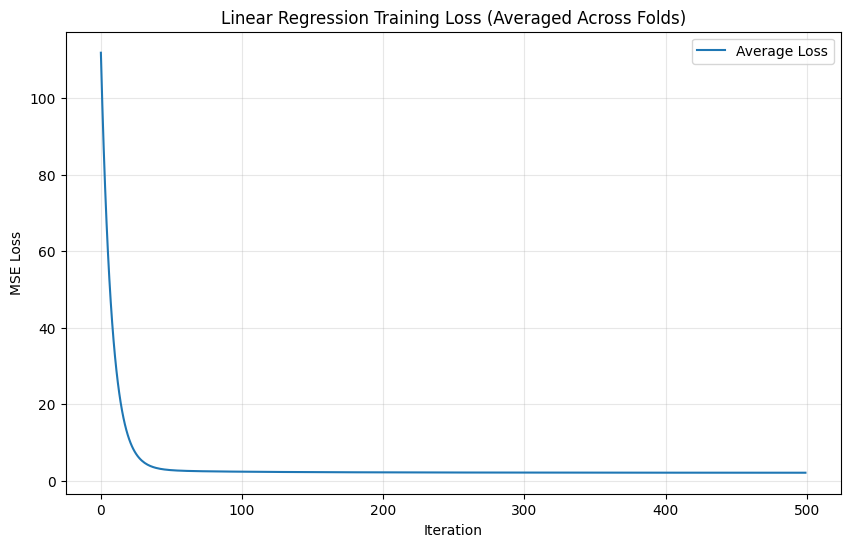

In [ ]:
average_losses = np.mean(lr_losses, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(average_losses, label='Average Loss')
plt.xlabel('Iteration')
plt.ylabel('MSE Loss')
plt.title('Linear Regression Training Loss (Averaged Across Folds)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
print("Linear Regression Results")
print(f"  Average MSE: {np.mean(lr_mse):.4f}")
print(f"  Average RMSE: {np.mean(lr_rmse):.4f}")
print(f"  Average R2:  {np.mean(lr_r2):.4f}")

Linear Regression Results
  Average MSE: 4.2645
  Average RMSE: 2.0458
  Average R2:  0.8280


---

# Part B: Scikit-Learn Regression Models

In [ ]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [ ]:
models = {
  "Ridge Regression": Ridge(alpha=1.0, max_iter=10000),
  "LASSO Regression": Lasso(alpha=1.0,  max_iter=10000),
  "Support Vector Machine": SVR(kernel='rbf'),
  "Decision Tree Regressor": DecisionTreeRegressor(max_depth=10),
  "Random Forest Regressor": RandomForestRegressor(n_estimators=200),
  "LightGBM": LGBMRegressor(verbose=-1),
  "CatBoost": CatBoostRegressor(verbose=0)
}

In [ ]:
# Storage for results
all_results = {}

for name in models:
  all_results[name] = {'mse': [], 'rmse': [], 'r2': []}

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold_idx, (train_index, test_index) in enumerate(kf.split(X)):
  print(f"\nFold {fold_idx + 1}/{n_splits}")

  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  for model_name, model in models.items():
    print(f"Training {model_name}...")

    # Train
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Calculate metrics
    mse = sklearn_mse(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Store results
    all_results[model_name]["mse"].append(mse)
    all_results[model_name]["rmse"].append(rmse)
    all_results[model_name]["r2"].append(r2)


Fold 1/5
Training Ridge Regression...
Training LASSO Regression...
Training Support Vector Machine...
Training Decision Tree Regressor...
Training Random Forest Regressor...
Training LightGBM...
Training CatBoost...

Fold 2/5
Training Ridge Regression...
Training LASSO Regression...
Training Support Vector Machine...
Training Decision Tree Regressor...
Training Random Forest Regressor...
Training LightGBM...
Training CatBoost...

Fold 3/5
Training Ridge Regression...
Training LASSO Regression...
Training Support Vector Machine...
Training Decision Tree Regressor...
Training Random Forest Regressor...
Training LightGBM...
Training CatBoost...

Fold 4/5
Training Ridge Regression...
Training LASSO Regression...
Training Support Vector Machine...
Training Decision Tree Regressor...
Training Random Forest Regressor...
Training LightGBM...
Training CatBoost...

Fold 5/5
Training Ridge Regression...
Training LASSO Regression...
Training Support Vector Machine...
Training Decision Tree Regres

# 5️⃣ Results Comparison


In [ ]:
for model_name in all_results:
  print(f"\n{model_name}:")
  print(f"  MSE:  {np.mean(all_results[model_name]['mse']):.4f}")
  print(f"  RMSE: {np.mean(all_results[model_name]['rmse']):.4f}")
  print(f"  R2:    {np.mean(all_results[model_name]['r2']):.4f}")


Ridge Regression:
  MSE:  3.0722
  RMSE: 1.7402
  R2:    0.8797

LASSO Regression:
  MSE:  23.0397
  RMSE: 4.7859
  R2:    0.1141

Support Vector Machine:
  MSE:  1.9297
  RMSE: 1.3726
  R2:    0.9264

Decision Tree Regressor:
  MSE:  1.2441
  RMSE: 1.1034
  R2:    0.9533

Random Forest Regressor:
  MSE:  0.5022
  RMSE: 0.7013
  R2:    0.9809

LightGBM:
  MSE:  1.0330
  RMSE: 1.0067
  R2:    0.9601

CatBoost:
  MSE:  0.6712
  RMSE: 0.7942
  R2:    0.9746


---

## Are our models good?

>Is RMSE = 1.00 good? How to know if a score is good or not?
>
>We need something to compare against. We need a Baseline.
>
>If our models are better than the baseline score, then they are good.

**The simplest baseline we can consider is the mean of the target**.

In [ ]:
# Calculate the baseline predictions (mean of the target)
baseline_pred = np.full_like(y, y.mean())

# Evaluate the baseline
baseline_mse = sklearn_mse(y, baseline_pred)
baseline_rmse = np.sqrt(baseline_mse)
baseline_r2 = r2_score(y, baseline_pred)

print(f"Baseline MSE (using mean target): {baseline_mse:.4f}")
print(f"Baseline RMSE (using mean target): {baseline_rmse:.4f}")
print(f"Baseline R2 (using mean target): {baseline_r2:.4f}")

Baseline MSE (using mean target): 27.0857
Baseline RMSE (using mean target): 5.2044
Baseline R2 (using mean target): 0.0000


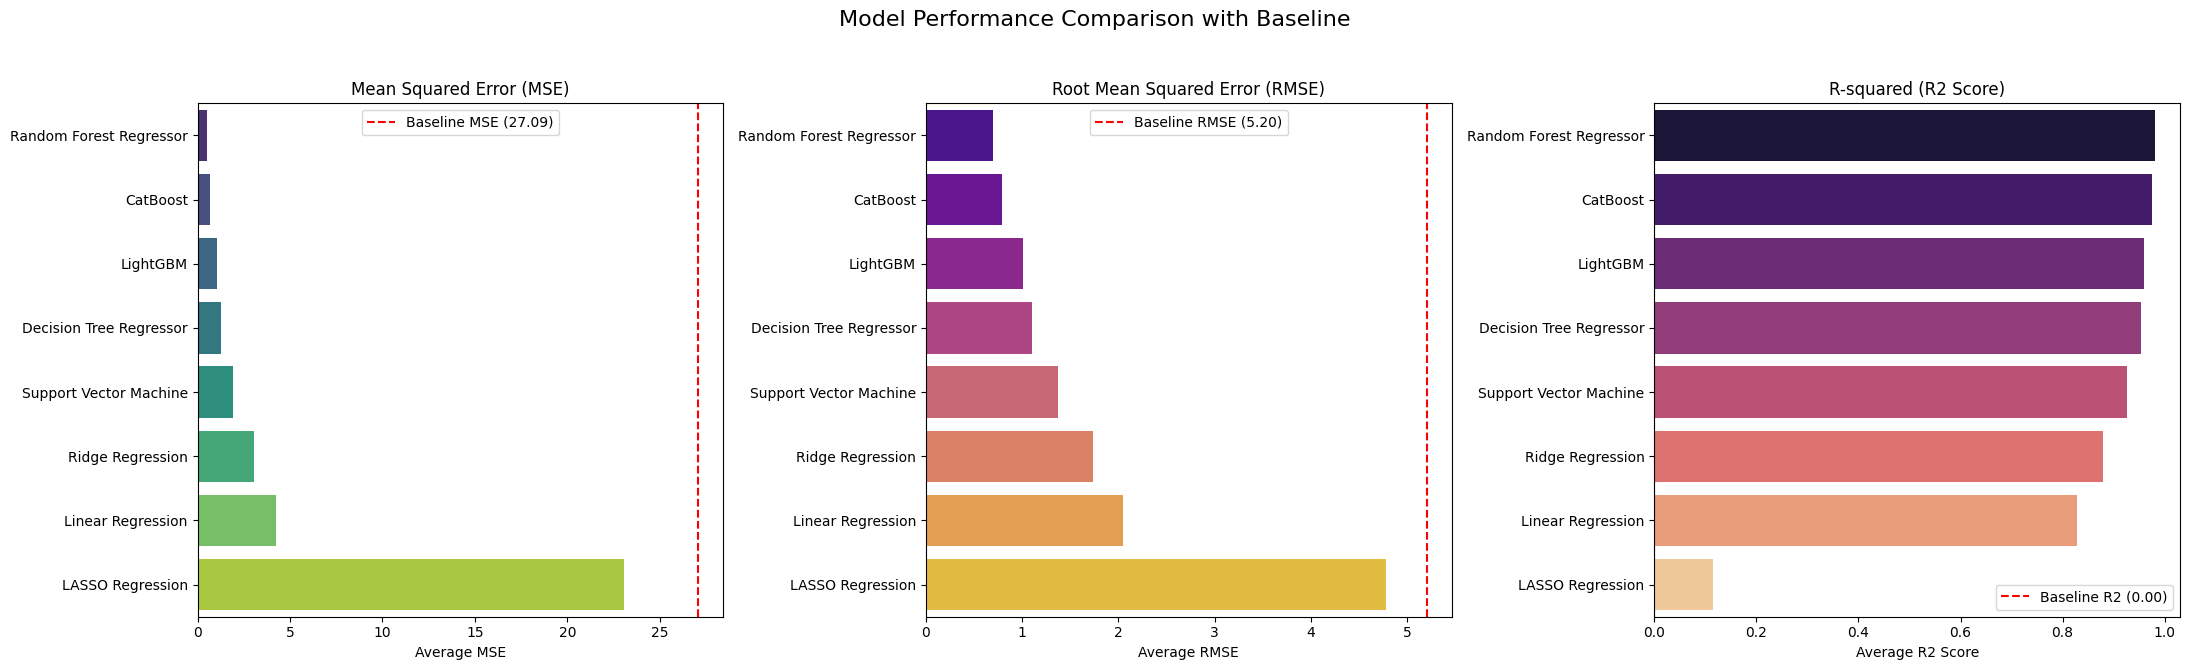

In [ ]:
# @title
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Consolidate all results into a single dictionary for plotting
plot_results = {
    "Linear Regression": {
        'mse': [np.mean(lr_mse)],
        'rmse': [np.mean(lr_rmse)],
        'r2': [np.mean(lr_r2)]
    }
}
plot_results.update(all_results)

# Prepare data for plotting
model_names = []
mse_scores = []
rmse_scores = []
r2_scores = []

for model_name, metrics in plot_results.items():
    model_names.append(model_name)
    mse_scores.append(np.mean(metrics['mse']))
    rmse_scores.append(np.mean(metrics['rmse']))
    r2_scores.append(np.mean(metrics['r2']))

results_df = pd.DataFrame({
    'Model': model_names,
    'MSE': mse_scores,
    'RMSE': rmse_scores,
    'R2': r2_scores
})

# Sort by R2 score for better visualization (higher is better)
results_df_sorted = results_df.sort_values(by='R2', ascending=False)

# Plotting the results with baseline
fig, axes = plt.subplots(1, 3, figsize=(22, 7))
fig.suptitle('Model Performance Comparison with Baseline', fontsize=16)

# MSE Plot (lower is better)
sns.barplot(x='MSE', y='Model', hue='Model', data=results_df_sorted.sort_values(by='MSE', ascending=True), ax=axes[0], palette='viridis', legend=False)
axes[0].set_title('Mean Squared Error (MSE)')
axes[0].set_xlabel('Average MSE')
axes[0].set_ylabel('')
axes[0].axvline(baseline_mse, color='red', linestyle='--', label=f'Baseline MSE ({baseline_mse:.2f})')
axes[0].legend()

# RMSE Plot (lower is better)
sns.barplot(x='RMSE', y='Model', hue='Model', data=results_df_sorted.sort_values(by='RMSE', ascending=True), ax=axes[1], palette='plasma', legend=False)
axes[1].set_title('Root Mean Squared Error (RMSE)')
axes[1].set_xlabel('Average RMSE')
axes[1].set_ylabel('')
axes[1].axvline(baseline_rmse, color='red', linestyle='--', label=f'Baseline RMSE ({baseline_rmse:.2f})')
axes[1].legend()

# R2 Plot (higher is better)
sns.barplot(x='R2', y='Model', hue='Model', data=results_df_sorted, ax=axes[2], palette='magma', legend=False)
axes[2].set_title('R-squared (R2 Score)')
axes[2].set_xlabel('Average R2 Score')
axes[2].set_ylabel('')
axes[2].axvline(baseline_r2, color='red', linestyle='--', label=f'Baseline R2 ({baseline_r2:.2f})')
axes[2].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

> **Our models are way better than this baseline!**


# 6️⃣ Feature Importance (Ridge & LASSO)

> For linear models like Ridge and LASSO, the coefficients tell us how important each feature is. Larger absolute values = more important features.

Linear models use coefficients `.coef_` a.k.a weights for each feature

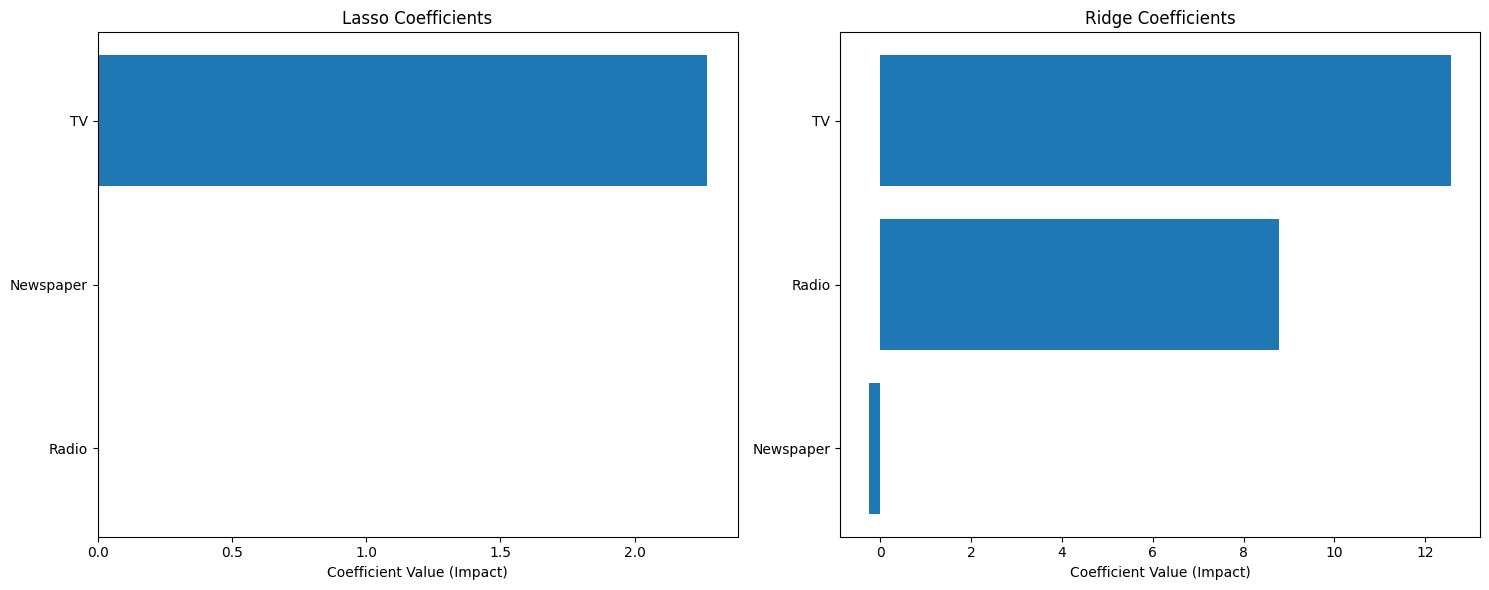

In [ ]:
coeffs = {}

coeffs['Lasso'] = models['LASSO Regression'].coef_
coeffs['Ridge'] = models['Ridge Regression'].coef_

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes = axes.flatten()
features = X.columns

for i, (model_name, coef) in enumerate(coeffs.items()):
  # Sort features by absolute coefficient value
  absolute_coef = np.abs(coef)
  sorted_idx = np.argsort(absolute_coef)

  ax = axes[i]
  ax.barh(features[sorted_idx], coef[sorted_idx])
  ax.set_title(f"{model_name} Coefficients")
  ax.set_xlabel("Coefficient Value (Impact)")

plt.tight_layout()
plt.show()

> **Observation:**
> - LASSO (L1 regularization) pushes some coefficients to exactly 0, effectively performing feature selection (TV).
>
> - Ridge (L2 regularization) smoothly shrinks coefficients but rarely sets them to 0.

### **Contribution: Sattam Altwaim** :)
**Extra notes by: Boushra Almazroua**